#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
df_stock1 = pd.read_csv("../static/data/wes.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8854,25/07/2022,47.509998,47.529999,46.680000,46.919998,46.919998,1684996.0,1.35,1.75,125.0
8855,26/07/2022,46.389999,46.400002,45.740002,45.950001,45.950001,1513593.0,1.35,1.75,125.0
8856,27/07/2022,45.900002,46.459999,45.520000,46.360001,46.360001,1700007.0,1.35,2.50,125.0
8857,28/07/2022,46.910000,46.919998,46.209999,46.299999,46.299999,1249420.0,1.35,2.50,125.0
8858,29/07/2022,46.599998,46.880001,46.470001,46.630001,46.630001,1896427.0,1.35,2.50,125.0


In [6]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.wes.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.wes.insert_many(records)

In [7]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wes.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.wes.delete_one(
    {'Date': last_date}
)

DELETE: 29/07/2022 46.630001


In [8]:
first_val=df_mongo.iloc[:,1].values
first_date = first_val[0]
print("FIRST DATA VALUE: "+first_date.strip('/02'))

FIRST DATA VALUE: 1/02/1988


In [9]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wes.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 28/07/2022 46.299999
Previous last date in MongoDb: 28-07-2022. Today's date: 03-08-2022


In [10]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'WES.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,46.919998,46.209999,46.910000,46.299999,1249420,46.299999
2022-07-29,46.880001,46.470001,46.599998,46.630001,1896427,46.630001
2022-08-01,46.974998,46.220001,46.590000,46.750000,1963566,46.750000
2022-08-02,47.590000,46.610001,46.849998,47.570000,1503797,47.570000


In [11]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,46.880001,46.470001,46.599998,46.630001,1896427,46.630001
2022-08-01,46.974998,46.220001,46.590000,46.750000,1963566,46.750000
2022-08-02,47.590000,46.610001,46.849998,47.570000,1503797,47.570000


In [12]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/07/2022,46.880001,46.470001,46.599998,46.630001,1896427,46.630001,1.35,2.5,125
1,01/08/2022,46.974998,46.220001,46.590000,46.750000,1963566,46.750000,1.35,2.5,125
2,02/08/2022,47.590000,46.610001,46.849998,47.570000,1503797,47.570000,1.35,2.5,125


UPDATE MONGO DB

In [13]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/07/2022',
  'High': 46.880001068115234,
  'Low': 46.470001220703125,
  'Open': 46.599998474121094,
  'Close': 46.630001068115234,
  'Volume': 1896427,
  'Adj Close': 46.630001068115234,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/08/2022',
  'High': 46.974998474121094,
  'Low': 46.220001220703125,
  'Open': 46.59000015258789,
  'Close': 46.75,
  'Volume': 1963566,
  'Adj Close': 46.75,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '02/08/2022',
  'High': 47.59000015258789,
  'Low': 46.61000061035156,
  'Open': 46.849998474121094,
  'Close': 47.56999969482422,
  'Volume': 1503797,
  'Adj Close': 47.56999969482422,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [14]:
#INSERT NEW DATA INTO MONGODB
db.wes.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.wes.find()))

last_val = df_mongo.iloc[-20:].values
print(last_val)

[[ObjectId('62e99db7a6603b576513a64d') '6/07/2022' 43.919998 44.41 43.66
  44.150002 44.150002 2204087.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a64e') '7/07/2022' 44.0 44.810001
  43.880001 44.779999 44.779999 1967706.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a64f') '8/07/2022' 44.849998 45.029999
  44.27 44.759998 44.759998 1653117.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a650') '11/07/2022' 44.849998 45.0 44.27
  44.439999 44.439999 1577381.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a651') '12/07/2022' 44.549999 45.02
  44.540001 44.779999 44.779999 1917254.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a652') '13/07/2022' 44.98 45.41 44.700001
  45.310001 45.310001 1919436.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a653') '14/07/2022' 45.299999 45.849998
  45.279999 45.509998 45.509998 1912467.0 1.35 1.75 125.0]
 [ObjectId('62e99db7a6603b576513a654') '15/07/2022' 45.0 45.965 44.860001
  45.93 45.93 2116117.0 1.35 1.75 125.0]
 [ObjectI

In [16]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 47.56999969482422


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [17]:
df_mongo = pd.DataFrame(list(db.wes.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8695, 1)

In [18]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [19]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6956, 1)

In [20]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 , 0.0051691 ,
       0.0051691 , 0.0051691 , 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286,
       0.00812286, 0.00812286, 0.00812286, 0.00812286, 0.00812286])]
[0.008122862643894602]


# Prepare train data for LSTM model

In [21]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6896, 60)

In [22]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6896, 60, 1)

# Build the LSTM model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6896/6896 [==============================] - 235s 34ms/step - loss: 1.6942e-04


In [26]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [27]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [28]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [29]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.005584360096681856

C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/3379501223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


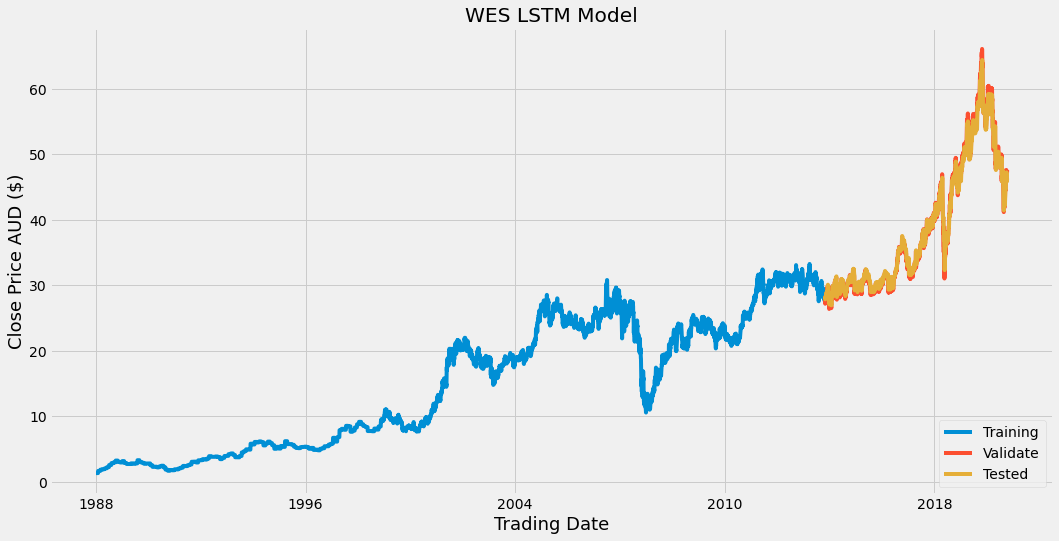

In [30]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WES LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
# x = np.arange(2000,2024,4)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2010,2018])
plt.savefig('../static/data/images/wes_graph.png')
plt.show()

# Test data Predictions on the Model

In [31]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6956  27.513271    28.219345   -0.706074
6957  27.776590    28.089153   -0.312563
6958  27.171669    28.089298   -0.917629
6959  27.854876    27.847967    0.006909
6960  27.861992    27.960505   -0.098513
...         ...          ...         ...
8690  46.360001    46.238777    0.121224
8691  46.299999    45.937229    0.362770
8692  46.630001    45.843353    0.786648
8693  46.750000    46.034374    0.715626
8694  47.570000    46.281563    1.288437

[1739 rows x 3 columns]>

In [32]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wes.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [33]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [34]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $47.56999969482422 Predicted next day share price $46


# Save the Model

In [35]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wes_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wes_sixty and load df

#PREDICT USING LOADED MODEL

In [36]:
from keras.models import load_model
model_in = load_model('../static/wes_model.sav')

In [37]:
# query the wes collection and load into dataframe

df_mongo = pd.DataFrame(list(db.wes.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[48.259998  ],
       [48.810001  ],
       [48.720001  ],
       [49.299999  ],
       [49.360001  ],
       [49.299999  ],
       [49.509998  ],
       [45.889999  ],
       [45.919998  ],
       [46.18      ],
       [46.150002  ],
       [46.07      ],
       [45.98      ],
       [46.400002  ],
       [47.07      ],
       [47.189999  ],
       [47.18      ],
       [46.825001  ],
       [46.939999  ],
       [46.830002  ],
       [45.52      ],
       [44.650002  ],
       [44.66      ],
       [43.669998  ],
       [40.029999  ],
       [41.59      ],
       [41.310001  ],
       [40.599998  ],
       [41.43      ],
       [42.209999  ],
       [42.150002  ],
       [42.985001  ],
       [43.130001  ],
       [43.990002  ],
       [42.459999  ],
       [42.080002  ],
       [41.91      ],
       [42.150002  ],
       [42.75      ],
       [42.82      ],
       [43.66      ],
       [43.880001  ],
       [44.27      ],
       [44.27      ],
       [44.540001  ],
       [44

#Create a function to loop through the days input

In [38]:
from keras.models import load_model
model_in = load_model('../static/wes_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wes(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_wes(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[46.31,
 46.32,
 46.28,
 46.23,
 46.18,
 46.13,
 46.08,
 45.95,
 45.87,
 45.79,
 45.71,
 45.65,
 45.59,
 45.54,
 45.5,
 45.48,
 45.45,
 45.44,
 45.43,
 45.42,
 45.41,
 45.41,
 45.4,
 45.4,
 45.39,
 45.4,
 45.39,
 45.39,
 45.4,
 45.41,
 45.41,
 45.42,
 45.43,
 45.43,
 45.43,
 45.43,
 45.43,
 45.44,
 45.44,
 45.45,
 45.46,
 45.47,
 45.47,
 45.48,
 45.49,
 45.49,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.51,
 45.5,
 45.5,
 45.5,
 45.5,
 45.5,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49,
 45.49

In [39]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  04-08-2022   Thursday
1        2  05-08-2022     Friday
2        3  08-08-2022     Monday
3        4  09-08-2022    Tuesday
4        5  10-08-2022  Wednesday
..     ...         ...        ...
203    204  16-05-2023    Tuesday
204    205  17-05-2023  Wednesday
205    206  18-05-2023   Thursday
206    207  19-05-2023     Friday
207    208  22-05-2023     Monday

[208 rows x 3 columns]>


In [40]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-03 00:00:00
-7 days, 15:58:03.879481
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [41]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [42]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/2683667932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


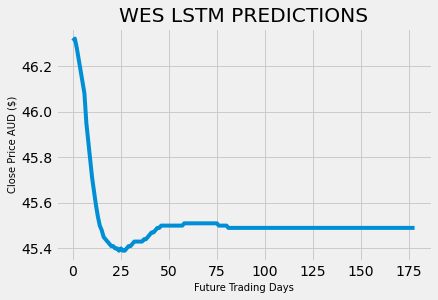

In [43]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('WES LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/wes_pred.png', bbox_inches="tight")
plt.show()

In [44]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 46.31}


In [45]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6956 8695 8873


C:\Users\antoi\AppData\Local\Temp/ipykernel_22228/1997212500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


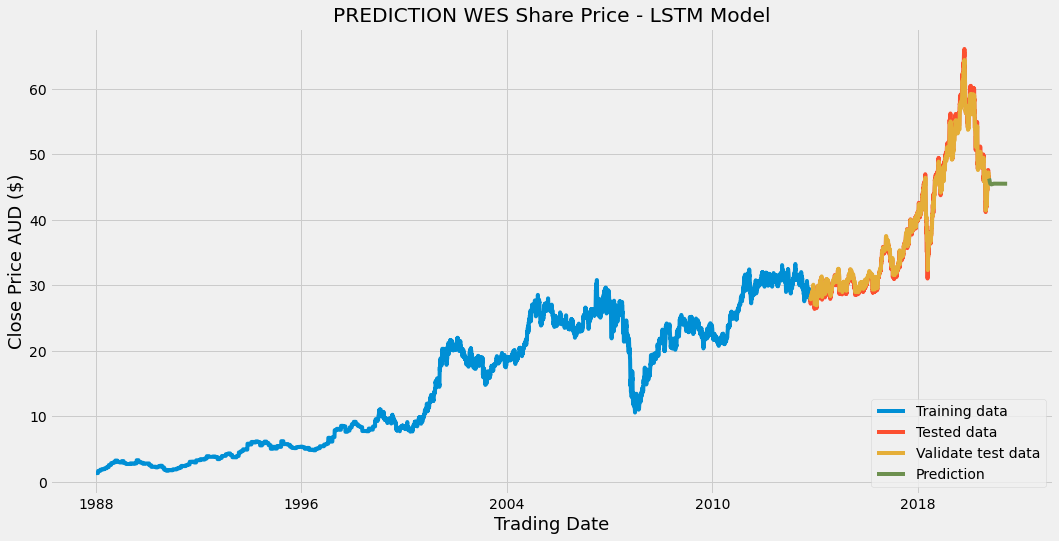

In [46]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION WES Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
# x = np.arange(2000,2024,4)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2010,2018])
plt.savefig('../static/data/images/wes_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [47]:
# Query all
name = 'WES'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e508895fb28a99d3939b6d'), 'model': 'LSTM', 'name': 'WES', 'date': '29/07/2022', 'predicted': 44, 'actual': 46.63, 'difference': -2.63, 'rmse': 0.96712}
{'_id': ObjectId('62e5c6f68d8c67d07d68d3dd'), 'model': 'RFR', 'name': 'WES', 'date': '29/07/2022', 'predicted': 44, 'actual': 46, 'difference': -1.0795, 'accuracy': 97.16}


In [48]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e5c6f68d8c67d07d68d3dd'), 'model': 'RFR', 'name': 'WES', 'date': '29/07/2022', 'predicted': 44, 'actual': 46, 'difference': -1.0795, 'accuracy': 97.16}


In [49]:
# Set keys and values of company
name = 'WES'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022,predicted $46, actual $47.57, difference -1.5700000000000003, rmse 0.00558


In [50]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e5c6f68d8c67d07d68d3dd'), 'model': 'RFR', 'name': 'WES', 'date': '29/07/2022', 'predicted': 44, 'actual': 46, 'difference': -1.0795, 'accuracy': 97.16}
{'_id': ObjectId('62e99ed6a6603b576513a662'), 'model': 'LSTM', 'name': 'WES', 'date': '02/08/2022', 'predicted': 46, 'actual': 47.57, 'difference': -1.57, 'rmse': 0.00558}


In [51]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': 